<a href="https://colab.research.google.com/github/YerimLee00/YBIGTA21/blob/main/0726_ML_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

os.chdir('/content/drive/MyDrive/YBIGTA/0726 ML')   # 경로 지정

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

train = pd.read_csv('movies_train.csv')
test = pd.read_csv('movies_test.csv')

# 데이터 전처리

In [4]:
# 결측치가 많은 데이터 제거
train = train.drop(['dir_prev_bfnum'],axis = 1)
test = test.drop(['dir_prev_bfnum'],axis = 1)

In [5]:
# 감독명 : 너무 다양해서 제거
train = train.drop(['director'],axis = 1)
test = test.drop(['director'],axis = 1)

In [6]:
# 제목 : 의미가 없기 때문에 제거
train = train.drop(['title'],axis= 1)
test = test.drop(['title'],axis= 1)

In [7]:
# 상위 5개의 배급사를 제외하고 '기타'로 처리
distributor_list = train.distributor.value_counts()[:5]
def func(distributor):
    if distributor in distributor_list:
        return distributor
    else:
        return '기타'

train['distributor'] = train['distributor'].apply(lambda x : func(x))
test['distributor'] = test['distributor'].apply(lambda x : func(x))

In [8]:
# 개봉일을 바탕으로 년,월 변수 생성
train['년'] = train['release_time'].apply(lambda x: int(x[:4]))
train['월'] = train['release_time'].apply(lambda x: int(x[5:7]))
train =  train.drop(['release_time'],axis = 1)

test['년'] = test['release_time'].apply(lambda x: int(x[:4]))
test['월'] = test['release_time'].apply(lambda x: int(x[5:7]))
test =  test.drop(['release_time'],axis = 1)

In [9]:
# 원핫 인코딩
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# 모델 생성 및 예측 (과제 부분)

In [10]:
train.head()

,time,dir_prev_num,num_staff,num_actor,box_off_num,년,월,distributor_(주)NEW,distributor_(주)마운틴픽쳐스,distributor_(주)쇼박스,...,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,96,0,91,2,23398,2012,11,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,130,2,387,3,7072501,2015,11,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,123,4,343,4,6959083,2013,6,0,0,1,...,0,0,0,0,1,0,0,1,0,0
3,101,2,20,6,217866,2012,7,1,0,0,...,0,0,0,0,0,1,0,0,1,0
4,108,1,251,2,483387,2010,11,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [11]:
train_x = train.drop(['box_off_num'],axis= 1)
train_y = train['box_off_num']

In [12]:
# 모델 성능 비교를 위한 Training Data / Validation Data 분리

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=21)

print(f'Training Dataset Shape : {X_train.shape}, {y_train.shape}')
print(f'Validation Dataset Shape : {X_val.shape}, {y_val.shape}')

Training Dataset Shape : (480, 28), (480,)
Validation Dataset Shape : (120, 28), (120,)


In [13]:
# Model 구축

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

log_clf = LogisticRegression(random_state=21)     # LogisticRegression
dt_clf = DecisionTreeClassifier(random_state=21, max_depth = None)     # DecisionTreeClassifier
svm_clf = SVC(probability = True, random_state=21)     # SVM Classifier
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('dt', dt_clf), ('svm', svm_clf)], voting='soft')     # VotingClassifier(위 3개의 Classifier 결합), Soft Voting

bag_clf = BaggingClassifier(dt_clf,     # base_estimator : DecisionTreeClassifier
                            bootstrap=True,     # bootstrap = True : Bagging
                            n_jobs=-1)     # n_jobs = - 1 : using all processors
pas_clf = BaggingClassifier(dt_clf,
                            bootstrap=False,     # bootstrap = False : Pasting
                            n_jobs=-1)

rf_clf = RandomForestClassifier(random_state=21, n_jobs=-1)   # RandomForestClassifier

et_clf = ExtraTreesClassifier(random_state=21, n_jobs=-1)   # ExtraTreesClassifier

ada_clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state=21, max_depth=1), learning_rate=0.01, random_state=123)   #AdaBoostClassifier

xgb_clf = XGBClassifier(random_state=21, eval_metric='rmse')   # XGBClassifier

In [14]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

models = [log_clf, dt_clf, svm_clf, voting_clf, bag_clf, pas_clf, rf_clf, et_clf, ada_clf, xgb_clf]
results = []

for model in models:
  model.fit(X_train, y_train)
  predict = model.predict(X_val)
  model, loss = model.__class__.__name__, mean_squared_error(predict, y_val, squared=False)   # Metric : RMSE
  results.append([model, loss])
  print(f'{model} Completed')

LogisticRegression Completed
DecisionTreeClassifier Completed
SVC Completed
VotingClassifier Completed
BaggingClassifier Completed
BaggingClassifier Completed
RandomForestClassifier Completed
ExtraTreesClassifier Completed
AdaBoostClassifier Completed
XGBClassifier Completed


In [15]:
results.sort(key = lambda x:x[1])

for result in results:
  print(result)

['BaggingClassifier', 1239199.1453175717]
['BaggingClassifier', 1294651.0237108814]
['SVC', 1419416.8190360523]
['XGBClassifier', 1438706.0725623795]
['AdaBoostClassifier', 1682002.318677789]
['RandomForestClassifier', 1736510.3939983365]
['ExtraTreesClassifier', 1879987.2081466406]
['LogisticRegression', 2026032.8916303923]
['DecisionTreeClassifier', 2126618.476104445]
['VotingClassifier', 2126618.476104445]


In [16]:
# XGBClassfier Tuning

from itertools import product

result = []

max_depth = [3, 6, 9]     # max_depth는 값을 3, 6, 9로 바꿔보면서,
min_child_weight = [1, 3, 5]     # min_child_weight는 값을 1, 3, 5로 바꿔보면서,
learning_rate = [0.001, 0.01, 0.1]   # learning_rate는 값을 0.001, 0.01, 0.1로 바꿔보면서 최적의 하이퍼파라미터 찾기
lst = list(product(*[max_depth, min_child_weight, learning_rate]))     # 가능한 모든 조합을 리스트로 저장

for max_depth, min_child_weight, learning_rate in lst:
  xgb_clf_temp = XGBClassifier(random_state=21, eval_metric='rmse', learning_rate=learning_rate,
                               max_depth=max_depth, min_child_weight=min_child_weight)
  xgb_clf_temp.fit(X_train, y_train)
  predict = xgb_clf_temp.predict(X_val)
  rmse = mean_squared_error(predict, y_val, squared=False)
  print("max_depth :", max_depth)
  print("min_child_weight :", min_child_weight)
  print("learning_rate :", learning_rate)
  print('RMSE :', rmse)   # 성능 평가
  result.append([max_depth, min_child_weight, learning_rate, rmse])
  print()

max_depth : 3
min_child_weight : 1
learning_rate : 0.001
RMSE : 1420329.26419316

max_depth : 3
min_child_weight : 1
learning_rate : 0.01
RMSE : 1419584.3369790416

max_depth : 3
min_child_weight : 1
learning_rate : 0.1
RMSE : 1438706.0725623795

max_depth : 3
min_child_weight : 3
learning_rate : 0.001
RMSE : 1421186.4612451193

max_depth : 3
min_child_weight : 3
learning_rate : 0.01
RMSE : 1421186.4612451193

max_depth : 3
min_child_weight : 3
learning_rate : 0.1
RMSE : 1421186.4612451193

max_depth : 3
min_child_weight : 5
learning_rate : 0.001
RMSE : 1421186.4612451193

max_depth : 3
min_child_weight : 5
learning_rate : 0.01
RMSE : 1421186.4612451193

max_depth : 3
min_child_weight : 5
learning_rate : 0.1
RMSE : 1421186.4612451193

max_depth : 6
min_child_weight : 1
learning_rate : 0.001
RMSE : 1420329.26419316

max_depth : 6
min_child_weight : 1
learning_rate : 0.01
RMSE : 1419584.3369790416

max_depth : 6
min_child_weight : 1
learning_rate : 0.1
RMSE : 1438706.0725623795

max_dept

In [21]:
result.sort(key = lambda x:x[3])

for result in result:
  print(result)   # RMSE가 가장 낮은 parameter로 모델 구축

[3, 1, 0.01, 1419584.3369790416]
[6, 1, 0.01, 1419584.3369790416]
[9, 1, 0.01, 1419584.3369790416]
[3, 1, 0.001, 1420329.26419316]
[6, 1, 0.001, 1420329.26419316]
[9, 1, 0.001, 1420329.26419316]
[3, 3, 0.001, 1421186.4612451193]
[3, 3, 0.01, 1421186.4612451193]
[3, 3, 0.1, 1421186.4612451193]
[3, 5, 0.001, 1421186.4612451193]
[3, 5, 0.01, 1421186.4612451193]
[3, 5, 0.1, 1421186.4612451193]
[6, 3, 0.001, 1421186.4612451193]
[6, 3, 0.01, 1421186.4612451193]
[6, 3, 0.1, 1421186.4612451193]
[6, 5, 0.001, 1421186.4612451193]
[6, 5, 0.01, 1421186.4612451193]
[6, 5, 0.1, 1421186.4612451193]
[9, 3, 0.001, 1421186.4612451193]
[9, 3, 0.01, 1421186.4612451193]
[9, 3, 0.1, 1421186.4612451193]
[9, 5, 0.001, 1421186.4612451193]
[9, 5, 0.01, 1421186.4612451193]
[9, 5, 0.1, 1421186.4612451193]
[3, 1, 0.1, 1438706.0725623795]
[6, 1, 0.1, 1438706.0725623795]
[9, 1, 0.1, 1438706.0725623795]


# 제출

In [22]:
submission = pd.read_csv('submission.csv')
submission

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0
...,...,...
238,해에게서 소년에게,0
239,울보 권투부,0
240,어떤살인,0
241,말하지 못한 비밀,0


In [23]:
# 제출용 Model 선별

bag_clf = BaggingClassifier(dt_clf,     # base_estimator : DecisionTreeClassifier
                            bootstrap=True,     # bootstrap = True : Bagging
                            n_jobs=-1)     # n_jobs = - 1 : using all processors
pas_clf = BaggingClassifier(dt_clf,
                            bootstrap=False,     # bootstrap = False : Pasting
                            n_jobs=-1)

svm_clf = SVC(probability = True)     # SVM Classifier

xgb_clf = XGBClassifier(eval_metric='rmse', learning_rate=0.01, max_depth=3, min_child_weight=1)

In [24]:
for model in [bag_clf, pas_clf, svm_clf, xgb_clf]:
  model.fit(train_x, train_y)
  predict = model.predict(test)
  submission['box_off_num'] = predict
  submission.to_csv(str(model.__class__.__name__)+'.csv',index = False)   # csv로 변환

# 제출 점수(과제부분)

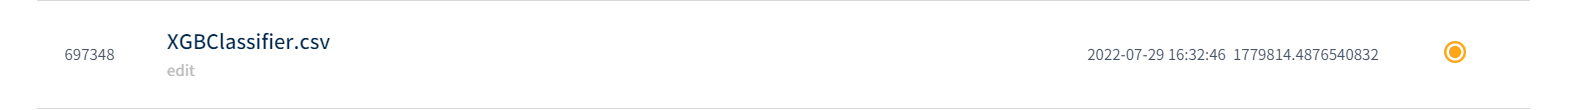